In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# getting the utils file here
import os, sys
import xbos_services_getter as xsg
import datetime
import calendar
import pytz
import numpy as np
import pandas as pd
import itertools
import time
from pathlib import Path
import pickle
import yaml
import process_indoor_data as pid
import create_models as ctm
import matplotlib.pyplot as plt

In [3]:
building_zone_name_stub = xsg.get_building_zone_names_stub()
building_zone_names = xsg.get_all_buildings_zones(building_zone_name_stub)

In [4]:
def forecasting(thermal_model, data, start, duration, seconds_prediction_window, dt, is_second_order=False):

    true_data = data.loc[start:]
    
    if true_data.index[-1] < start + datetime.timedelta(seconds=duration) or true_data.index[0] != start:
        return None
    
    forecast = []

    curr_time = true_data.index[0]
    
    while curr_time <= start + datetime.timedelta(seconds=duration):
        if curr_time not in true_data.index:
            return None
        
        curr_row = true_data.loc[curr_time].to_frame().T

        if (len(forecast) < 2 and is_second_order) or (len(forecast) < 1):
            forecast.append(float(curr_row["t_in"].values))
        else:
            curr_row["t_in"] = forecast[-1]
            if is_second_order:
                curr_row["t_prev"] = forecast[-2]
            forecast.append(thermal_model.predict(curr_row)[0])

        curr_time += datetime.timedelta(seconds=float(dt.loc[curr_time]))

    
    forecast = forecast[:-1] # otherwise might predict beyond the set end
    return pd.Series(index=true_data.index[:len(forecast)], data=forecast)
    

In [ ]:
dt = processed_data.loc[test_X.index[0]:test_X.index[-1]]["dt"]

N = test_X.shape[0]

forecasts = []

for i in range(N):

    start_time = test_X.index[i]
    forecast = forecasting(reg, test_X, start_time, 6*60*60, 5*60, dt, is_second_order=True)
    
    if forecast is not None:
        forecasts.append(forecast)
        
    if i % 500 == 0:
        print("Iteration:", i)
        print("Successful Forecasts:", len(forecasts))


# Get Model


## Will do some small hyperparameter search

In [30]:
VAL_START = datetime.datetime(year=2018, month=12, day=5, hour=17, minute=47).replace(tzinfo=pytz.utc)
VAL_END = datetime.datetime(year=2019, month=2, day=11, hour=5, minute=11).replace(tzinfo=pytz.utc)

In [7]:
def save_model(model, feature_order, config):
    building, zone = config["building"], config["zone"]
    
    model_dir = Path(__file__).parent  / "saved_models" / building
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)

    dir_path = model_dir / (zone + "_" + config["method"] + "_" + str(config["is_second_order"]) + "_" + str(config["use_occupancy"]) + "_" + str(config["curr_action_timesteps"]) + "_" + str(config["prev_action_timesteps"]))
    
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    with open(str(dir_path / "model.pkl"), "wb") as f:
        pickle.dump(model, f)
        
    with open(str(dir_path / "feature_order.pkl"), "wb") as f:
        pickle.dump(feature_order, f)
        
    with open(str(dir_path / "config.pkl"), "wb") as f:
        pickle.dump(config, f)
        
        

In [8]:
def load_model(config):
    building, zone = config["building"], config["zone"]
    
    model_dir = Path(__file__).parent / "saved_models" / building
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)

    dir_path = model_dir / (zone + "_" + config["method"] + "_" + str(config["is_second_order"]) + "_" + str(config["use_occupancy"]) + "_" + str(config["curr_action_timesteps"]) + "_" + str(config["prev_action_timesteps"]))

    if os.path.isdir(str(dir_path)):
        try:
            with open(str(dir_path / "model.pkl"), "rb") as f:
                model = pickle.load(f)
            with open(str(dir_path / "feature_order.pkl"), "rb") as f:
                feature_order = pickle.load(f)
            with open(str(dir_path / "config.pkl"), "rb") as f:
                config = pickle.load(f)
            return model, feature_order, config, None
        except:
            return None, None, None, "Missing model files in dir: " + str(dir_path)
    
    return None, None, None, "No Model Folder found"
            
            
            

In [84]:
def get_err(X, y, model, column_order, action=-1):
    if action != -1:
        filter_arr = (X["action"] == action)
        X = X[filter_arr]
        y = y[filter_arr]

    if X.shape[0] == 0:
        return None, "Not enough data for given action to get error."
    X = X[column_order]
    predictions_train = model.predict(X)
    error = (y.values - predictions_train)

    return np.sqrt(np.mean(error ** 2))

In [85]:
def get_val_err(start, end, config, model, column_order):
    config = config.copy()
    
    config["start"] = start
    config["end"] = end
    config["train_ratio"] = 1
    train_X, train_y, test_X, test_y, err = ctm.get_train_test(building=config["building"],
                                                 zone=config["zone"],
                                                 start=config["start"],
                                                 end=config["end"],
                                                 prediction_window=config["prediction_window"],
                                                 raw_data_granularity=config["raw_data_granularity"],
                                                 train_ratio=config["train_ratio"],
                                                 is_second_order=config["is_second_order"],
                                                 use_occupancy=config["use_occupancy"],
                                                 curr_action_timesteps=config["curr_action_timesteps"],
                                                 prev_action_timesteps=config["prev_action_timesteps"],
                                                 check_data=config["check_data"])

    return [get_err(train_X, train_y, model, column_order, action) for action in [-1, 0, 1, 2]]

In [14]:
config = {
    
    "start":None,
    "end":None,
    "prediction_window":"5m",
    "raw_data_granularity":"1m",
    "train_ratio":1,
    "check_data":False,
    "method": "OLS",
    "is_second_order": True,
    "use_occupancy": False,
    "curr_action_timesteps": 0,
    "prev_action_timesteps": -1
}
                    

for bldg in ["avenal-veterans-hall", "avenal-animal-shelter", "south-berkeley-senior-center"]:
    print("Building", bldg)
    print("Zone", building_zone_names[bldg][0])
    
    config["building"] = bldg
    config["zone"] = building_zone_names[bldg][0]

    model_loaded, column_order_loaded, config_loaded, err = load_model(config)
    if err is not None:
        model, column_order, err = ctm.create_model(building=config["building"],
                                     zone=config["zone"],
                                     start=config["start"],
                                     end=config["end"],
                                     prediction_window=config["prediction_window"],
                                     raw_data_granularity=config["raw_data_granularity"],
                                     train_ratio=config["train_ratio"],
                                     is_second_order=config["is_second_order"],
                                     use_occupancy=config["use_occupancy"],
                                     curr_action_timesteps=config["curr_action_timesteps"],
                                     prev_action_timesteps=config["prev_action_timesteps"],
                                     method=config["method"],
                                     check_data=config["check_data"])
        
    save_model(model, column_order, config)




Building avenal-veterans-hall
Zone hvac_zone_ac_3
Building avenal-animal-shelter
Zone hvac_zone_shelter_corridor
Building south-berkeley-senior-center
Zone hvac_zone_ac_2


In [86]:
config = {
    "building" : "avenal-veterans-hall",
    "zone":building_zone_names[building][0],
    "start":None,
    "end":None,
    "prediction_window":"5m",
    "raw_data_granularity":"1m",
    "train_ratio":0.65,
    "check_data":False
}

for method in ["OLS", "RF"]:
    print("Method", method)
    for is_second_order in [True, False]:
        print("Second Order", is_second_order)
        for use_occupancy in [True, False]:
            print("Occupanc", use_occupancy)
            for curr_action_timesteps in [1, 5]:
                print("Action Timesteps", curr_action_timesteps)
                for prev_action_timesteps in [-1, 0, 1, 5]:
                    print("Prev Action Timesteps", prev_action_timesteps)
                    
                    config["method"] = method
                    config["is_second_order"] = is_second_order
                    config["use_occupancy"] = use_occupancy
                    config["curr_action_timesteps"] = curr_action_timesteps
                    config["prev_action_timesteps"] = prev_action_timesteps
                    
                    model, err = load_model(config)
                    if err is not None:
                        model, column_order, err = ctm.create_model(building=config["building"],
                                                     zone=config["zone"],
                                                     start=config["start"],
                                                     end=config["end"],
                                                     prediction_window=config["prediction_window"],
                                                     raw_data_granularity=config["raw_data_granularity"],
                                                     train_ratio=config["train_ratio"],
                                                     is_second_order=config["is_second_order"],
                                                     use_occupancy=config["use_occupancy"],
                                                     curr_action_timesteps=config["curr_action_timesteps"],
                                                     prev_action_timesteps=config["prev_action_timesteps"],
                                                     method=config["method"],
                                                     check_data=config["check_data"])
                        save_model(model, config)

                    curr_err = get_val_err(VAL_START, VAL_END, config, model, column_order)
                    val_err.append([config, curr_err])
                    print("---------------")
                    print(val_err)
                    print("---------------")

                    
                    

Method OLS
Second Order True
Occupanc True
Action Timesteps 1
Prev Action Timesteps -1


/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/daniellengyel/BETS/XBOS/services/indoor_temperature_prediction/process_indoor_data.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data["action"] = data["action"].map(f)


---------------
[[{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.3795427293912211, 0.15103337993903412, 0.7642912649975057, 0.6099386222962687]], [{'building': 'avenal-veterans-hall', 'zone': 'hvac_zone_ac_3', 'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>), 'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>), 'prediction_window': '5m', 'raw_data_granularity': '1m', 'train_ratio': 1, 'check_data': False, 'method': 'OLS', 'is_second_order': True, 'use_occupancy': True, 'curr_action_timesteps': 0, 'prev_action_timesteps': 5}, [0.17645745219135434, 0.14313959756354075, 0.2622935883214274, 0.7726454470907884]], [{'b

In [88]:
with open("./val_err.pkl", "wb") as f:
    pickle.dump(val_err, f)

In [93]:
min_err = float("inf")
min_err_obj = None
for c in val_err:
    if c[1][0] < min_err:
        min_err = c[1][0]
        min_err_obj = c

In [94]:
min_err_obj

[{'building': 'avenal-veterans-hall',
  'zone': 'hvac_zone_ac_3',
  'start': datetime.datetime(2018, 12, 5, 17, 47, tzinfo=<UTC>),
  'end': datetime.datetime(2019, 2, 11, 5, 11, tzinfo=<UTC>),
  'prediction_window': '5m',
  'raw_data_granularity': '1m',
  'train_ratio': 1,
  'check_data': False,
  'method': 'OLS',
  'is_second_order': True,
  'use_occupancy': True,
  'curr_action_timesteps': 0,
  'prev_action_timesteps': 5},
 [0.17605665689892527,
  0.14295509690048994,
  0.2625844038402571,
  0.5077744810225149]]

## Get forecasting error plots

In [136]:
# for bldg in ["avenal-animal-shelter", "south-berkeley-senior-center"]:
for bldg in ["avenal-veterans-hall"]:
    print("Building", bldg)
    config = {
        "building" : bldg,
        "zone":building_zone_names[bldg][0],
        "start":None,
        "end":None,
        "prediction_window":"5m",
        "raw_data_granularity":"1m",
        "train_ratio":0.70,
        "check_data":False,
        "method": "OLS",
        "is_second_order" : True,
        "use_occupancy" : False,
        "curr_action_timesteps" : 0,
        "prev_action_timesteps" : -1
    }

    model, err = load_model(config)
    if err is not None:
        model, column_order, err = ctm.create_model(building=config["building"],
                                     zone=config["zone"],
                                     start=config["start"],
                                     end=config["end"],
                                     prediction_window=config["prediction_window"],
                                     raw_data_granularity=config["raw_data_granularity"],
                                     train_ratio=config["train_ratio"],
                                     is_second_order=config["is_second_order"],
                                     use_occupancy=config["use_occupancy"],
                                     curr_action_timesteps=config["curr_action_timesteps"],
                                     prev_action_timesteps=config["prev_action_timesteps"],
                                     method=config["method"],
                                     check_data=config["check_data"])
        save_model(model, config)
    
    train_X, train_y, test_X, test_y, err = ctm.get_train_test(building=config["building"],
                                                 zone=config["zone"],
                                                 start=config["start"],
                                                 end=config["end"],
                                                 prediction_window=config["prediction_window"],
                                                 raw_data_granularity=config["raw_data_granularity"],
                                                 train_ratio=config["train_ratio"],
                                                 is_second_order=config["is_second_order"],
                                                 use_occupancy=config["use_occupancy"],
                                                 curr_action_timesteps=config["curr_action_timesteps"],
                                                 prev_action_timesteps=config["prev_action_timesteps"],
                                                 check_data=config["check_data"])
    
    # dt = processed_data.loc[test_X.index[0]:test_X.index[-1]]["dt"]

    N = test_X.shape[0]

    forecasts = []
    
    for i in range(N):

        start_time = test_X.index[i]
        forecast = forecasting(model, test_X, start_time, 6*60*60, 5*60, is_second_order=True)

        if forecast is not None:
            forecasts.append(forecast)

        if i % 500 == 0:
            print("Percent Done:", 100 * i/float(N))
            print("Successful Forecasts:", len(forecasts))
    save_forecast(forecasts, config)
    print("")

Building avenal-veterans-hall
Percent Done: 0.0
Successful Forecasts: 1
Percent Done: 2.284043670914988
Successful Forecasts: 501
Percent Done: 4.568087341829976
Successful Forecasts: 1001
Percent Done: 6.852131012744963
Successful Forecasts: 1501
Percent Done: 9.136174683659952
Successful Forecasts: 1863
Percent Done: 11.42021835457494
Successful Forecasts: 2242
Percent Done: 13.704262025489927
Successful Forecasts: 2742
Percent Done: 15.988305696404915
Successful Forecasts: 3068
Percent Done: 18.272349367319904
Successful Forecasts: 3156
Percent Done: 20.55639303823489
Successful Forecasts: 3396
Percent Done: 22.84043670914988
Successful Forecasts: 3396
Percent Done: 25.124480380064867
Successful Forecasts: 3550
Percent Done: 27.408524050979853
Successful Forecasts: 3658
Percent Done: 29.692567721894843
Successful Forecasts: 3746
Percent Done: 31.97661139280983
Successful Forecasts: 3980
Percent Done: 34.26065506372482
Successful Forecasts: 4283
Percent Done: 36.54469873463981
Succes

In [126]:
min_len = float("inf")
max_len = 0
lens = []
for f in forecasts:
    if len(f) > max_len:
        max_len = len(f)
    if len(f) < min_len:
        min_len = len(f)
    lens.append(len(f))

In [127]:
np.mean(lens)

71.80692724996523

In [134]:

forecasts_used = []
for f in forecasts:
    if len(f) < 68:
        continue
    else:
        forecasts_used.append(f[:68])
errs = []

for i in range(len(forecasts_used)):
    forecast = forecasts_used[i]
    real_data = test_X.loc[forecast.index]["t_in"]
    errs.append(forecast - real_data) # assuming all forecasts have the same length. 
        
errs = np.vstack(errs)
errs = np.square(errs)
errs = np.mean(errs, axis=0)
errs = np.sqrt(errs)

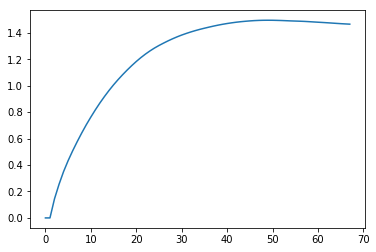

In [135]:
plt.plot(errs)
plt.show()

In [105]:
def forecasting(thermal_model, data, start, duration, dt, is_second_order=False):

    true_data = data.loc[start:]
    
    if true_data.index[-1] < start + datetime.timedelta(seconds=duration) or true_data.index[0] != start:
        return None
    
    forecast = []

    curr_time = true_data.index[0]
    timestep = 0
    
    while curr_time <= start + datetime.timedelta(seconds=duration):
        if curr_time not in true_data.index:
            if true_data.index[timestep] < (curr_time + datetime.timedelta(seconds=float(dt))):
                curr_time = true_data.index[timestep]
            else:
                return None
        
        curr_row = true_data.loc[curr_time].to_frame().T

        if (len(forecast) < 2 and is_second_order) or (len(forecast) < 1):
            forecast.append(float(curr_row["t_in"].values))
        else:
            curr_row["t_in"] = forecast[-1]
            if is_second_order:
                curr_row["t_prev"] = forecast[-2]
            forecast.append(thermal_model.predict(curr_row)[0])

        curr_time += datetime.timedelta(seconds=float(dt))
        timestep += 1
    
    forecast = forecast[:-1] # otherwise might predict beyond the set end
    return pd.Series(index=true_data.index[:len(forecast)], data=forecast)
    

In [112]:
def save_forecast(forecast,config):
    building, zone = config["building"], config["zone"]
    
    model_dir = Path.cwd() / "saved_forecasts" / building
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)

    file_path = model_dir / (zone+ ".pkl")

    with open(str(file_path), "wb") as f:
        pickle.dump(model, f)
        
def load_forecast(config):
    building, zone = config["building"], config["zone"]
    
    model_dir = Path.cwd() / "saved_forecasts" / building
    if not os.path.isdir(model_dir):
        return None, "No forecast found"

    file_path = model_dir / (zone + ".pkl")

    if os.path.isfile(str(file_path)):
        with open(str(file_path), "rb") as f:
            forecast = pickle.load(f)
        return forecast, None
    return None, "No forecast found"
        
            

In [104]:
# dt = processed_data.loc[test_X.index[0]:test_X.index[-1]]["dt"]

N = test_X.shape[0]

forecasts = []

for i in range(N):

    start_time = test_X.index[i]
    forecast = forecasting(model, test_X, start_time, 6*60*60, 5*60, is_second_order=True)
    
    if forecast is not None:
        forecasts.append(forecast)
        
    if i % 500 == 0:
        print("Percent Done:", 100 * i/float(N))
        print("Successful Forecasts:", len(forecasts))


Percent Done: 0.0
Successful Forecasts: 0
Percent Done: 2.284043670914988
Successful Forecasts: 469
Percent Done: 4.568087341829976
Successful Forecasts: 569
Percent Done: 6.852131012744963
Successful Forecasts: 607
Percent Done: 9.136174683659952
Successful Forecasts: 696
Percent Done: 11.42021835457494
Successful Forecasts: 810
Percent Done: 13.704262025489927
Successful Forecasts: 862
Percent Done: 15.988305696404915
Successful Forecasts: 930
Percent Done: 18.272349367319904
Successful Forecasts: 949
Percent Done: 20.55639303823489
Successful Forecasts: 949
Percent Done: 22.84043670914988
Successful Forecasts: 949
Percent Done: 25.124480380064867
Successful Forecasts: 1006
Percent Done: 27.408524050979853
Successful Forecasts: 1011
Percent Done: 29.692567721894843
Successful Forecasts: 1011
Percent Done: 31.97661139280983
Successful Forecasts: 1032
Percent Done: 34.26065506372482
Successful Forecasts: 1165
Percent Done: 36.54469873463981
Successful Forecasts: 1200
Percent Done: 38.8

In [113]:
save_forecast(forecasts, config)

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


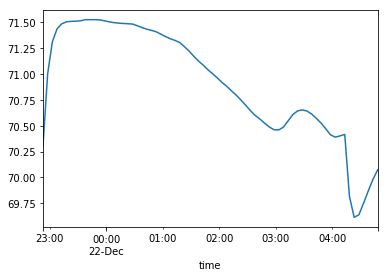

In [115]:
forecasts[0].plot()

/Users/daniellengyel/miniconda3/envs/venv-dr3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


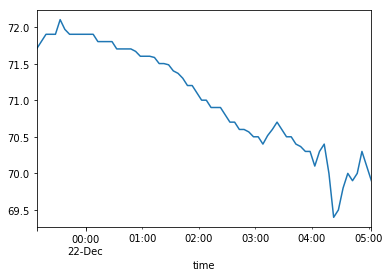

In [111]:
test_X.iloc[30:72+30]["t_in"].plot()

In [108]:
6 * 60 / 5

72.0

In [114]:
forecast = load_forecast(config)